# Translate dates from human to machine format with attention mechanism

This notebook is based on the programming assignment "Neural machine translation" of deeplearning.ai, course Sequence models, week Sequence models and Attention mechanism. It was implemented in Keras and I reimplemented it using TensorFlow 1.14. The figure with the network architecture is taken from that assignment.

We will build a model to translate human readable dates ("25th of June, 2009", "03/30/1968") into machine readable dates ("2009-06-25", "1968-03-30") using the attention mechanism.

The attention mechanism tells a Neural Machine Translation model where it should pay attention to at any step. 

## Learning objectives

- Use of unidirectional and bidirectional LSTM neural network architecture in TensorFlow
- Apply the attention mechanism
- Applying the concept of "reuse" for variables in TensorFlow
- Use Adam optimizer with decay rate

In [1]:
import numpy as np

from faker import Faker
import random
from tqdm import tqdm
from babel.dates import format_date
from nmt_utils import *
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import time

import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import tensorflow as tf
print(tf.__version__)

config = tf.ConfigProto()
config.gpu_options.allow_growth=True

Using TensorFlow backend.
/home/vgkortsas/.conda/envs/TensorFlow_practice/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/vgkortsas/.conda/envs/TensorFlow_practice/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/vgkortsas/.conda/envs/TensorFlow_practice/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint1

1.14.0


In [2]:
import warnings

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

Default GPU Device: /device:GPU:0


In [3]:
m = 10000
dataset, human_vocab, machine_vocab, inv_machine_vocab = load_dataset(m)

100%|██████████| 10000/10000 [00:00<00:00, 22073.52it/s]


In [4]:
dataset[9990:] # list of tuples of (human readable date, machine readable date)

[('25 april 1982', '1982-04-25'),
 ('thursday september 20 1984', '1984-09-20'),
 ('sunday march 11 1973', '1973-03-11'),
 ('saturday april 29 1978', '1978-04-29'),
 ('saturday january 30 1982', '1982-01-30'),
 ('20.01.19', '2019-01-20'),
 ('monday july 7 1975', '1975-07-07'),
 ('october 9 1983', '1983-10-09'),
 ('tuesday july 2 1974', '1974-07-02'),
 ('21 aug 2000', '2000-08-21')]

In [5]:
human_vocab # python dictionary mapping all characters used in the human readable dates to an integer-valued index

{' ': 0,
 '.': 1,
 '/': 2,
 '0': 3,
 '1': 4,
 '2': 5,
 '3': 6,
 '4': 7,
 '5': 8,
 '6': 9,
 '7': 10,
 '8': 11,
 '9': 12,
 '<pad>': 36,
 '<unk>': 35,
 'a': 13,
 'b': 14,
 'c': 15,
 'd': 16,
 'e': 17,
 'f': 18,
 'g': 19,
 'h': 20,
 'i': 21,
 'j': 22,
 'l': 23,
 'm': 24,
 'n': 25,
 'o': 26,
 'p': 27,
 'r': 28,
 's': 29,
 't': 30,
 'u': 31,
 'v': 32,
 'w': 33,
 'y': 34}

In [6]:
machine_vocab # python dictionary mapping all characters used in machine readable dates to an integer-valued index. 
# These indices are not necessarily consistent with human_vocab.

{'-': 0,
 '0': 1,
 '1': 2,
 '2': 3,
 '3': 4,
 '4': 5,
 '5': 6,
 '6': 7,
 '7': 8,
 '8': 9,
 '9': 10}

In [7]:
inv_machine_vocab # inverse dictionary of machine_vocab, mapping from indices back to characters

{0: '-',
 1: '0',
 2: '1',
 3: '2',
 4: '3',
 5: '4',
 6: '5',
 7: '6',
 8: '7',
 9: '8',
 10: '9'}

We preprocess the data and map the raw text data into the index values. We will also use Tx=30 (which we assume is the maximum length of the human readable date; if we get a shorter date, it is further padded to $T_x$ values with a special character < pad >; if we get a longer input, we would have to truncate it) and Ty=10 (since "YYYY-MM-DD" is 10 characters long). 

In [8]:
def preprocess_data(dataset, human_vocab, machine_vocab, Tx, Ty):
    
    X, Y = zip(*dataset)
    
    X = np.array([string_to_int(i, Tx, human_vocab) for i in X])
    Y = [string_to_int(t, Ty, machine_vocab) for t in Y]

    return X, np.array(Y)

In [9]:
Tx = 30
Ty = 10
X_train_original, Y_train_original = preprocess_data(dataset, human_vocab, machine_vocab, Tx, Ty)

print("X_train.shape:", X_train_original.shape)
print("Y_train.shape:", Y_train_original.shape)

X_train.shape: (10000, 30)
Y_train.shape: (10000, 10)


In [10]:
index = 0
print("Source date:", dataset[index][0])
print("Target date:", dataset[index][1])
print()
print("Source after preprocessing (indices):", X_train_original[index])
print("Target after preprocessing (indices):", Y_train_original[index])
print()

Source date: 9 may 1998
Target date: 1998-05-09

Source after preprocessing (indices): [12  0 24 13 34  0  4 12 12 11 36 36 36 36 36 36 36 36 36 36 36 36 36 36
 36 36 36 36 36 36]
Target after preprocessing (indices): [ 2 10 10  9  0  1  6  0  1 10]



## Network architecture and Attention mechanism

The diagram on the left shows the attention model. The diagram on the right shows what one "Attention" step does to calculate the attention variables $\alpha^{\langle t, t' \rangle}$, which are used to compute the context variable $context^{\langle t \rangle}$ for each timestep in the output ($t=1, \ldots, T_y$). Both diagrams are taken from the programming assignment "Neural machine translation" of deeplearning.ai


<img src="images/attention.png" style="width:500;height:500px;"> <br>

In [11]:
def get_batches(x, y, batch_size):
    
    n_batches = len(x)//batch_size
    x, y = x[:n_batches*batch_size], y[:n_batches*batch_size]
    for ii in range(0, len(x), batch_size):
        yield x[ii:ii+batch_size], y[ii:ii+batch_size]

In [12]:
def length(sequence):   
    
  used = tf.sign(tf.reduce_max(tf.abs(sequence), 2))
  length = tf.reduce_sum(used, 1)
  length = tf.cast(length, tf.int32)
  return length

In [13]:
def build_inputs():
    
    inputs_ = tf.placeholder(tf.int32,[None,None],name='inputs_')
    labels_ = tf.placeholder(tf.int32,[None,None],name='labels_')
    
    return inputs_, labels_

In [14]:
def build_post_attention_lstm(lstm_size, lstm_layers, batch_size):
    
    # Basic LSTM cell
    lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size) 
        
    # Stack up multiple LSTM layers, for deep learning
    cell = tf.contrib.rnn.MultiRNNCell([lstm for _ in range(lstm_layers)])
    
    # Getting an initial state of all zeros
    initial_state = cell.zero_state(batch_size, tf.float32)

    return cell, initial_state

In [15]:
def build_bidirectional_lstm(lstm_size, lstm_layers, batch_size):
    
    # Basic LSTM cell
    lstm_fw = tf.contrib.rnn.BasicLSTMCell(lstm_size) 
    lstm_bw = tf.contrib.rnn.BasicLSTMCell(lstm_size) 
    
    # Stack up multiple LSTM layers, for deep learning
    cell_fw = tf.contrib.rnn.MultiRNNCell([lstm_fw for _ in range(lstm_layers)])
    cell_bw = tf.contrib.rnn.MultiRNNCell([lstm_bw for _ in range(lstm_layers)])
        
    return cell_fw, cell_bw

In [16]:
def one_step_attention(bidirectional_outputs_concat, s_prev, Tx, reuse, scope1,scope2):
    
    s_prev_repeator=tf.tile(tf.expand_dims(s_prev,1), [1, Tx, 1])
    bidirectional_outputs_sprev_concat=tf.concat([bidirectional_outputs_concat,s_prev_repeator],axis=2)
        
    densor1=tf.contrib.layers.fully_connected(bidirectional_outputs_sprev_concat, 10, activation_fn=tf.nn.tanh,
                                             reuse=reuse, scope=scope1, 
                                              weights_initializer = tf.keras.initializers.glorot_uniform())
    
    densor2=tf.contrib.layers.fully_connected(densor1, 1, activation_fn=tf.nn.relu,reuse=reuse, scope=scope2,
                                             weights_initializer = tf.keras.initializers.glorot_uniform())
    
    alphas=tf.nn.softmax(densor2,axis=1)
    context=tf.reduce_sum( tf.multiply(alphas, bidirectional_outputs_concat),axis=1, keep_dims=True )
    
    return context

In [17]:
def build_loss(predictions, targets, num_classes, Ty):
        
    # num_classes is len(machine_vocab)    
    y_one_hot = tf.one_hot(targets, depth=num_classes)
    y_one_hot_swap=tf.transpose(y_one_hot, [1, 0, 2])
   
    total_loss = None
    for kkk in range(Ty):
        output_loss = tf.keras.losses.categorical_crossentropy(y_true=y_one_hot_swap[kkk], y_pred=predictions[kkk], from_logits=False)
        
        if total_loss is None:
            total_loss = output_loss
        else:
            total_loss += output_loss
        
    loss = tf.reduce_mean(total_loss)
    
    return loss 

In [18]:
def build_accuracy(predictions, targets, num_classes):
        
    # num_classes is len(machine_vocab)    
    y_one_hot = tf.one_hot(targets, depth=num_classes)
    y_one_hot_swap=tf.transpose(y_one_hot, [1, 0, 2])
        
    accuracy = tf.reduce_mean(tf.cast(tf.reduce_all(tf.reduce_all(tf.equal(y_one_hot_swap,tf.round(predictions)),0),1),tf.float32))
        
    return accuracy 

In [19]:
def build_optimizer(loss, learning_rate, decay_rate):
    
    global_step = tf.Variable(1, trainable=False) 
    
    learning_rate = learning_rate / (1. + decay_rate * tf.cast(global_step,tf.float32))
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss, global_step)
     
    return optimizer, learning_rate

In [20]:
class machine_translation_model:
    
    def __init__(self, human_vocab_size, batch_size, 
                       bi_lstm_size, bi_lstm_layers, post_attention_lstm_size, post_attention_lstm_layers,
                         learning_rate, Tx, Ty, test_mode=False):
        
        if (test_mode==True):
            batch_size=1
            reuse=tf.AUTO_REUSE
        else:
            reuse=False
            
        tf.reset_default_graph()
        
        # Build the input placeholder tensors
        self.inputs_, self.labels_ = build_inputs()

        # one-hot encode the input tokens
        x_one_hot = tf.one_hot(self.inputs_, human_vocab_size)
        
        logits_list=[]
        predictions_list=[]
        
        # Build the Bidirectional LSTM cell
        cell_fw, cell_bw = build_bidirectional_lstm(bi_lstm_size, bi_lstm_layers, batch_size)
                
        bidirectional_outputs, bidirectional_output_states = tf.nn.bidirectional_dynamic_rnn(cell_fw, cell_bw, 
                                                        x_one_hot, sequence_length=length(x_one_hot), dtype=tf.float32)
            
        self.bidirectional_outputs=bidirectional_outputs
        self.bidirectional_outputs_concat=tf.concat([self.bidirectional_outputs[0],
                                                     self.bidirectional_outputs[1]],axis=2)
         
        # s_prev for 1st step, equal to all 0s
        post_attention_cell, self.post_attention_initial_state = build_post_attention_lstm(post_attention_lstm_size,
                                                                            post_attention_lstm_layers, batch_size)
        
        self.s_prev=self.post_attention_initial_state[0][1]
        self.post_attention_state=self.post_attention_initial_state
        
        scope1='densor1'
        scope2='densor2'
        
        # Iterate for Ty steps
        for t in range(Ty):
            
            if (t>=1):
                reuse = True
            
            # Perform one step of the attention mechanism to get back the context vector at step t 
            self.context = one_step_attention(self.bidirectional_outputs_concat, self.s_prev, Tx, reuse, scope1, scope2)
        
            # Apply the post-attention LSTM cell to the "context" vector.
            self.post_attention_lstm_output, state = tf.nn.dynamic_rnn(post_attention_cell, 
                                                        self.context, initial_state=self.post_attention_state)
            
            self.post_attention_state = state
            self.s_prev = self.post_attention_state[0][1]
        
            # Apply fully connected layer to the hidden state output of the post-attention LSTM
            self.logits = tf.contrib.layers.fully_connected(self.post_attention_lstm_output[:,0,:], 
                            len(machine_vocab), activation_fn=None,reuse=reuse, 
                            scope='softmax', weights_initializer = tf.keras.initializers.glorot_uniform())

            self.predictions = tf.nn.softmax(self.logits,axis=1)
            
            logits_list.append(self.logits)
            predictions_list.append(self.predictions)
        

        self.logits_list = tf.stack(logits_list)
        self.predictions_list = tf.stack(predictions_list)
        
        self.loss = build_loss(self.predictions_list, self.labels_ , len(machine_vocab), Ty)
       
        self.accuracy = build_accuracy(self.predictions_list, self.labels_ , len(machine_vocab))
        self.optimizer, self.learning_rate = build_optimizer(self.loss, learning_rate, decay_rate)

In [21]:
post_attention_lstm_size = 64
post_attention_lstm_layers = 1
bi_lstm_size = 32
bi_lstm_layers = 1
batch_size = 100
human_vocab_size = len(human_vocab)
learning_rate = 0.005
decay_rate = 0.01

## Number of trainable parameters

In [22]:
model = machine_translation_model(human_vocab_size=human_vocab_size, batch_size=batch_size, 
                       bi_lstm_size=bi_lstm_size, bi_lstm_layers=bi_lstm_layers, post_attention_lstm_size=post_attention_lstm_size,
                        post_attention_lstm_layers=post_attention_lstm_layers, learning_rate=learning_rate, Tx=Tx, Ty=Ty)

with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())

    total_parameters = 0
    for variable in tf.trainable_variables():
        print(variable)
        # shape is an array of tf.Dimension
        shape = variable.get_shape()
        print('shape of weight matrix: ',shape)
        #print(len(shape))
        variable_parameters = 1
        for dim in shape:
            #print(dim)
            variable_parameters *= dim.value
        print('number of trainable parameters: ',variable_parameters)
        print('------------------------------')
        total_parameters += variable_parameters
    print('total number of trainable parameters: ',total_parameters)

W0221 01:34:29.302094 140173553436480 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0221 01:34:29.302865 140173553436480 deprecation.py:323] From <ipython-input-15-3fc5a43386fa>:4: BasicLSTMCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
W0221 01:34:29.303718 140173553436480 deprecation.py:323] From <ipython-input-15-3fc5a43386fa>:8: MultiRNNCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions

<tf.Variable 'bidirectional_rnn/fw/multi_rnn_cell/cell_0/basic_lstm_cell/kernel:0' shape=(69, 128) dtype=float32_ref>
shape of weight matrix:  (69, 128)
number of trainable parameters:  8832
------------------------------
<tf.Variable 'bidirectional_rnn/fw/multi_rnn_cell/cell_0/basic_lstm_cell/bias:0' shape=(128,) dtype=float32_ref>
shape of weight matrix:  (128,)
number of trainable parameters:  128
------------------------------
<tf.Variable 'bidirectional_rnn/bw/multi_rnn_cell/cell_0/basic_lstm_cell/kernel:0' shape=(69, 128) dtype=float32_ref>
shape of weight matrix:  (69, 128)
number of trainable parameters:  8832
------------------------------
<tf.Variable 'bidirectional_rnn/bw/multi_rnn_cell/cell_0/basic_lstm_cell/bias:0' shape=(128,) dtype=float32_ref>
shape of weight matrix:  (128,)
number of trainable parameters:  128
------------------------------
<tf.Variable 'densor1/weights:0' shape=(128, 10) dtype=float32_ref>
shape of weight matrix:  (128, 10)
number of trainable paramet

## explanation of weight matrices shapes

* The training variables are:
    * Variable:  bidirectional_rnn/fw/multi_rnn_cell/cell_0/basic_lstm_cell/kernel:0, Shape:  (68, 128)
       
      68 because the input to each LSTM gate is the concatenation of inputs of size (100,36) and the 32 LSTM nodes, thus (100,68)
      
      128 because LSTM has 4 gates with 32 nodes and thus 4*32=128
     
    * Variable:  rnn/multi_rnn_cell/cell_0/basic_lstm_cell/kernel:0, Shape: (128, 256)
      
      This refers to the post-attention LSTM, which has inputs conext and s_prev
      context has shape (100,1,64), since bidirectional_outputs_concat has shape (100,30,64)
      
      128 because 64 from context and 64 from LSTM nodes
      
      256 because LSTM has 4 gates with 64 nodes and thus 4*64=256
      
    * Variable:  softmax/softmax_w:0, Shape: (64, 11)
    
      64 because the input to softmax is the output of post-attention LSTM which has 64 nodes
      
      11 are the classes

## Training

Epoch: 1/5000 Train loss (mean) : 16.5775203705 Accuracy (mean): 0.000000 learning rate : 0.00250000
Epoch: 11/5000 Train loss (mean) : 1.4584093094 Accuracy (mean): 0.648200 learning rate : 0.00041667
Epoch: 21/5000 Train loss (mean) : 0.4140474796 Accuracy (mean): 0.925100 learning rate : 0.00022727
Epoch: 31/5000 Train loss (mean) : 0.1879713386 Accuracy (mean): 0.970900 learning rate : 0.00015625
Epoch: 41/5000 Train loss (mean) : 0.1011791602 Accuracy (mean): 0.988200 learning rate : 0.00011905
Epoch: 51/5000 Train loss (mean) : 0.0603768937 Accuracy (mean): 0.995300 learning rate : 0.00009615
Epoch: 61/5000 Train loss (mean) : 0.0384733528 Accuracy (mean): 0.998000 learning rate : 0.00008065
Epoch: 71/5000 Train loss (mean) : 0.0253517050 Accuracy (mean): 0.999200 learning rate : 0.00006944
Epoch: 81/5000 Train loss (mean) : 0.0170362908 Accuracy (mean): 0.999900 learning rate : 0.00006098
Epoch: 91/5000 Train loss (mean) : 0.0116962399 Accuracy (mean): 1.000000 learning rate : 0

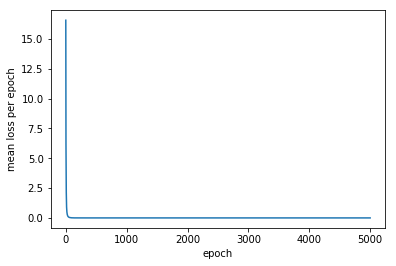

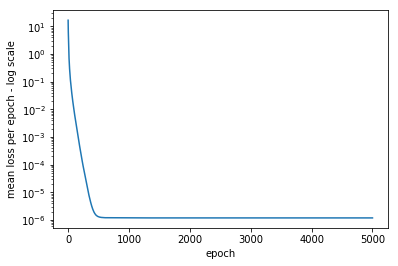

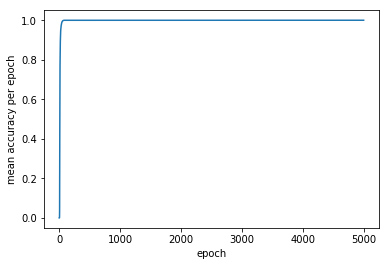

In [23]:
tf.reset_default_graph()
nb_epochs = 5000
epochs = nb_epochs

model = machine_translation_model(human_vocab_size=human_vocab_size, batch_size=batch_size, 
                       bi_lstm_size=bi_lstm_size, bi_lstm_layers=bi_lstm_layers, post_attention_lstm_size=post_attention_lstm_size,
                        post_attention_lstm_layers=post_attention_lstm_layers, learning_rate=learning_rate, Tx=Tx, Ty=Ty)

saver = tf.train.Saver(max_to_keep=epochs) 

train_loss_mean = []
train_acc_mean = []

with tf.Session(config=config) as sess:
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())

    start_time = time.time()
    
    for e in range(epochs):
        
        train_acc = []
        train_loss = []
        
        post_attention_state_val = sess.run(model.post_attention_initial_state)
         
        # shuffling the data
        permutated = np.arange(X_train_original.shape[0])
        np.random.shuffle(permutated)
        X_train = X_train_original[permutated]
        Y_train = Y_train_original[permutated]

        for (x_train, y_train) in get_batches(X_train, Y_train, batch_size):
            feed = {model.inputs_: x_train,
                   model.labels_: y_train,
                   model.post_attention_initial_state: post_attention_state_val}
                       
            batch_loss, batch_accuracy,_,batch_learning_rate = sess.run([model.loss,
                                                        model.accuracy,
                                                        model.optimizer, model.learning_rate],
                                feed_dict=feed)
           
            train_loss.append(batch_loss)
            train_acc.append(batch_accuracy)
                                    
        if (e<=200):
            if (e%10==0):
                print("Epoch: {}/{}".format(e+1, epochs),
                      "Train loss (mean) : {:.10f}".format(np.mean(train_loss)),
                      "Accuracy (mean): {:.6f}".format(np.mean(train_acc)),
                       "learning rate : {:.8f}".format(batch_learning_rate))
        elif (e>200 and e < 2000):
            if (e%200==0):
                print("Epoch: {}/{}".format(e+1, epochs),
                      "Train loss (mean) : {:.10f}".format(np.mean(train_loss)),
                      "Accuracy (mean): {:.6f}".format(np.mean(train_acc)),
                       "learning rate : {:.8f}".format(batch_learning_rate))
        else:
            if (e%500==0):
                print("Epoch: {}/{}".format(e+1, epochs),
                      "Train loss (mean) : {:.10f}".format(np.mean(train_loss)),
                      "Accuracy (mean): {:.6f}".format(np.mean(train_acc)),
                      "learning rate : {:.8f}".format(batch_learning_rate))            
            
        train_loss_mean.append(np.mean(train_loss))
        train_acc_mean.append(np.mean(train_acc))

        if (e%20 == 0):
            saver.save(sess, "checkpoints/epoch_{}.ckpt".format(e+1))
              
    duration=time.time()-start_time
    print("duration: {:.1f} sec".format(duration))
    saver.save(sess, "checkpoints/translation.ckpt")
    
fig = plt.figure()
plt.plot(np.arange(1,epochs+1), train_loss_mean)
plt.ylabel('mean loss per epoch')
plt.xlabel('epoch')

fig = plt.figure()
plt.plot(np.arange(1,epochs+1), train_loss_mean)
plt.ylabel('mean loss per epoch - log scale')
plt.xlabel('epoch')
plt.yscale('log')

fig = plt.figure()
plt.plot(np.arange(1,epochs+1), train_acc_mean)
plt.ylabel('mean accuracy per epoch')
plt.xlabel('epoch')

## Test the model on unseen examples (i.e. human readable dates)    

In [26]:
EXAMPLES = ['3 May 1979', '5 April 09', '21th of August 2016', 'Tue 10 Jul 2007', 'Saturday May 9 2018', 
            'March 3 2001', 'March 3rd 2001', '1 March 2001', '21st of August 2016', 'August 21 2016',
            '3/27/70', '18.10.89','saturday september 29 1984', '8 01 16', '12th of November 2032',
           '11th of November 2010', 'April 3rd 2010', 'April 2nd 2010', 'April 1st 2010', 'December 3rd 2010', 
            'December 3th 2010', '3rd of December 2010', '4th of December 2010', 'December 4th 2010', 'December 5th 2010',
           '6th of December 2010', '11th of August 2016', 'Friday 3 May 1995', '10th June 1900','10th June 1980']

model = machine_translation_model(human_vocab_size=human_vocab_size, batch_size=1,
                       bi_lstm_size=bi_lstm_size, bi_lstm_layers=bi_lstm_layers, post_attention_lstm_size=post_attention_lstm_size,
                        post_attention_lstm_layers=post_attention_lstm_layers, learning_rate=learning_rate, Tx=Tx, Ty=Ty,
                                     test_mode=True)

with tf.Session() as sess:
    saver = tf.train.Saver()
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    test_post_attention_state_val = sess.run(model.post_attention_initial_state)
        
    for example in EXAMPLES:
        source = string_to_int(example, Tx, human_vocab)   
        x=np.array(source)
        x=x.reshape(1,-1)
    
        batches = get_batches(X_train_original[:1], Y_train_original[:1], 1)
        x1, y = next(batches)
    
        feed = {model.inputs_: x,
                   model.labels_: y,
                   model.post_attention_initial_state: test_post_attention_state_val}
            
            
        test_predictions_list = sess.run(model.predictions_list,
                                feed_dict=feed)
        
        prediction = np.argmax(test_predictions_list, axis = -1)
        output = [inv_machine_vocab[int(i)] for i in prediction]
        print("source:", example)
        print("output:", ''.join(output))
        print()

source: 3 May 1979
output: 1979-05-03

source: 5 April 09
output: 2009-04-05

source: 21th of August 2016
output: 2016-08-21

source: Tue 10 Jul 2007
output: 2007-07-10

source: Saturday May 9 2018
output: 2018-05-09

source: March 3 2001
output: 2001-03-03

source: March 3rd 2001
output: 2001-03-03

source: 1 March 2001
output: 2001-03-01

source: 21st of August 2016
output: 2016-08-21

source: August 21 2016
output: 2016-08-21

source: 3/27/70
output: 1970-03-27

source: 18.10.89
output: 1989-10-18

source: saturday september 29 1984
output: 1984-09-29

source: 8 01 16
output: 2016-01-08

source: 12th of November 2032
output: 2033-11-12

source: 11th of November 2010
output: 2010-11-11

source: April 3rd 2010
output: 2010-04-03

source: April 2nd 2010
output: 2010-04-02

source: April 1st 2010
output: 2010-04-01

source: December 3rd 2010
output: 2010-12-03

source: December 3th 2010
output: 2010-02-03

source: 3rd of December 2010
output: 2010-12-03

source: 4th of December 2010
out

## It translates correctly 24 out of the 30 given unseen human readable dates into machine readable format